In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data_model.csv', index_col = 0)
df.sample(5)

,T1,F1,F2,F3,F4,F5,F6,T2,T3,F7,F8,F9,F10
820.0,0.596783,1930.389172,789.798256,64.812581,20.749293,264.844169,589.344541,78.598663,2051.958320,307.363639,1.0,11.046367,68.112439
302.0,3.627405,1991.091938,652.401598,130.853934,20.732132,234.500692,353.471451,73.390029,2748.078194,132.911274,0.0,12.723886,68.647153
755.0,3.104559,1858.862775,307.232901,84.541511,27.920843,223.294202,415.463131,70.713530,2347.684613,248.318925,1.0,7.213099,50.353296
735.0,1.397467,2005.502050,755.383225,88.536497,23.864561,245.543354,264.281505,80.691499,2404.068921,184.661639,1.0,4.385964,59.485083
217.0,4.414416,1901.586009,1000.289288,98.244089,24.481028,288.401849,399.870134,81.203147,2371.299242,251.359279,0.0,2.511647,75.348275


In [8]:
x = df["T1"]

In [9]:
y = df["T3"]

In [10]:
dt = pd.DataFrame({'Соотношение' : x, 'Прочность' : y})
dt.head()

,Соотношение,Прочность
0.0,1.857143,3000.0
1.0,1.857143,3000.0
2.0,1.857143,3000.0
3.0,1.857143,3000.0
4.0,2.771331,3000.0


Далее мы подгоним модель квантильной регрессии, используя соотношение в качестве переменной-предиктора и прочность в качестве переменной-ответа.

Мы будем использовать модель для прогнозирования ожидаемого 90-го процентиля прочности на основе соотношения:

In [11]:
#fit the model
model = smf.quantreg('y ~ x', dt).fit(q=0.9)

#view model summary
print(model.summary())

                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:             0.003942
Model:                       QuantReg   Bandwidth:                       191.2
Method:                 Least Squares   Sparsity:                        2750.
Date:                Mon, 25 Apr 2022   No. Observations:                 1000
Time:                        17:12:37   Df Residuals:                      998
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2908.8424     86.046     33.806      0.000    2739.991    3077.694
x             49.0849     27.744      1.769      0.077      -5.358     103.528


Мы также можем визуализировать результаты регрессии, создав диаграмму рассеяния с подобранным уравнением квантильной регрессии, наложенным на график:

Text(0, 0.5, 'Прочность')

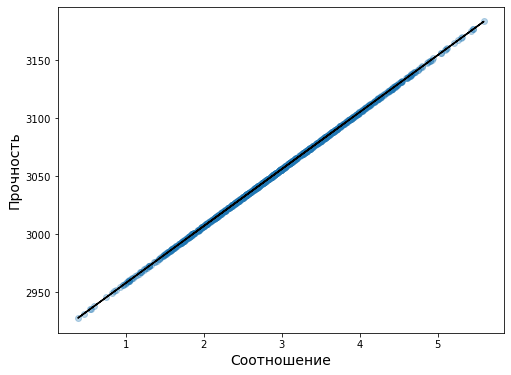

In [16]:
#define figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

#get y values
get_y = lambda a, b: a + b * x
y = get_y(model.params['Intercept'], model.params['x'])

#plot data points with quantile regression equation overlaid
ax.plot(x, y, color='black')
ax.scatter(x, y, alpha=.3)
ax.set_xlabel('Соотношение', fontsize=14)
ax.set_ylabel('Прочность', fontsize=14)

Чтобы проиллюстрировать поведение квантильной регрессии, мы создадим два синтетических набора данных. Истинные генеративные случайные процессы для обоих наборов данных будут состоять из одного и того же ожидаемого значения с линейной зависимостью с одним признаком x.

In [17]:
rng = np.random.RandomState(42)
x = np.linspace(start=0, stop=10, num=100)
X = x[:, np.newaxis]
y_true_mean = 10 + 0.5 * x

Мы создадим две последующие проблемы, изменив распределение цели yпри сохранении того же ожидаемого значения:

в первом случае добавляется гетероскедастический нормальный шум;

во втором случае добавляется асимметричный шум Парето.

In [18]:
y_normal = y_true_mean + rng.normal(loc=0, scale=0.5 + 0.5 * x, size=x.shape[0])
a = 5
y_pareto = y_true_mean + 10 * (rng.pareto(a, size=x.shape[0]) - 1 / (a - 1))

Давайте сначала визуализируем наборы данных, а также распределение остатков .y - mean(y)

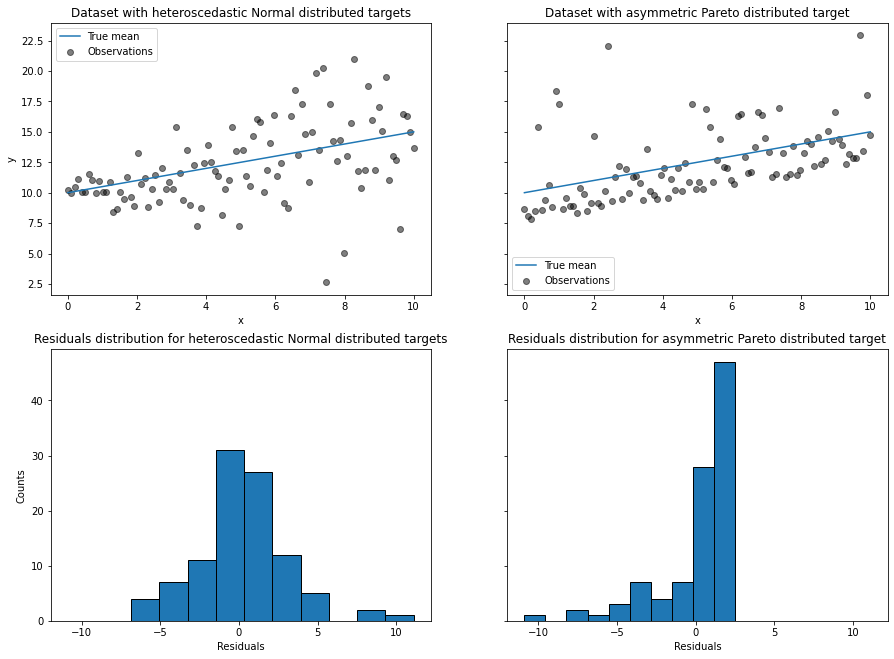

In [19]:
_, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11), sharex="row", sharey="row")

axs[0, 0].plot(x, y_true_mean, label="True mean")
axs[0, 0].scatter(x, y_normal, color="black", alpha=0.5, label="Observations")
axs[1, 0].hist(y_true_mean - y_normal, edgecolor="black")


axs[0, 1].plot(x, y_true_mean, label="True mean")
axs[0, 1].scatter(x, y_pareto, color="black", alpha=0.5, label="Observations")
axs[1, 1].hist(y_true_mean - y_pareto, edgecolor="black")

axs[0, 0].set_title("Dataset with heteroscedastic Normal distributed targets")
axs[0, 1].set_title("Dataset with asymmetric Pareto distributed target")
axs[1, 0].set_title(
    "Residuals distribution for heteroscedastic Normal distributed targets"
)
axs[1, 1].set_title("Residuals distribution for asymmetric Pareto distributed target")
axs[0, 0].legend()
axs[0, 1].legend()
axs[0, 0].set_ylabel("y")
axs[1, 0].set_ylabel("Counts")
axs[0, 1].set_xlabel("x")
axs[0, 0].set_xlabel("x")
axs[1, 0].set_xlabel("Residuals")
_ = axs[1, 1].set_xlabel("Residuals")

С гетероскедастической нормально распределенной целью мы наблюдаем, что дисперсия шума увеличивается, когда значение признака xувеличивается.

С асимметричной распределенной по Парето целью мы наблюдаем, что положительные остатки ограничены.

Эти типы зашумленных целей делают оценку через LinearRegressionменее эффективной, т. е. нам нужно больше данных для получения стабильных результатов, и, кроме того, большие выбросы могут иметь огромное влияние на подобранные коэффициенты. (Иными словами: в условиях постоянной дисперсии обычные оценки методом наименьших квадратов сходятся к истинным коэффициентам намного быстрее с увеличением размера выборки.)

В этой асимметричной настройке медиана или разные квантили дают дополнительную информацию. Кроме того, медианная оценка гораздо более устойчива к выбросам и распределениям с тяжелыми хвостами. Но обратите внимание, что экстремальные квантили оцениваются по очень важным точкам данных. 95% квантилей более или менее оцениваются по 5% наибольшим значениям и, таким образом, также являются немного чувствительными выбросами.

В оставшейся части этого урока мы покажем, как QuantileRegressorэто можно использовать на практике, и дадим интуитивное представление о свойствах подогнанных моделей. Наконец, мы сравним оба QuantileRegressor и LinearRegression.

В этом разделе мы хотим оценить условную медиану, а также нижний и верхний квантили, фиксированные на уровне 5% и 95% соответственно. Таким образом, мы получим три линейные модели, по одной на каждый квантиль.

Мы будем использовать квантили на уровне 5% и 95%, чтобы найти выбросы в обучающей выборке за пределами центрального интервала 90%.

In [20]:
from sklearn.linear_model import QuantileRegressor

quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X, y_normal).predict(X)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y_normal
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y_normal
        )

Теперь мы можем построить три линейные модели и выделенные выборки, которые находятся в пределах центрального 90-процентного интервала, из выборок, которые находятся за пределами этого интервала.

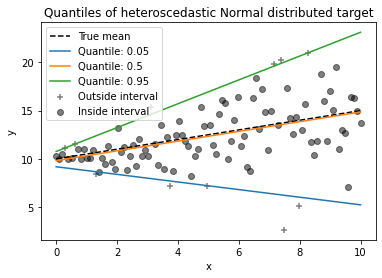

In [21]:
plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    x[out_bounds_predictions],
    y_normal[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y_normal[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")

Поскольку шум по-прежнему имеет нормальное распределение, в частности, является симметричным, истинное условное среднее и истинное условное медиана совпадают. Действительно, мы видим, что предполагаемая медиана почти совпадает с истинным средним значением. Мы наблюдаем эффект увеличения дисперсии шума на квантилях 5% и 95%: наклоны этих квантилей сильно различаются, и интервал между ними становится шире с увеличением x.

Чтобы получить дополнительную интуицию относительно значения оценок квантилей 5% и 95%, можно подсчитать количество выборок выше и ниже предсказанных квантилей (представленных крестом на графике выше), учитывая, что у нас есть в общей сложности 100 образцы.

Мы можем повторить тот же эксперимент, используя асимметричную цель с распределением по Парето.

In [22]:
quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X, y_pareto).predict(X)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y_pareto
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y_pareto
        )

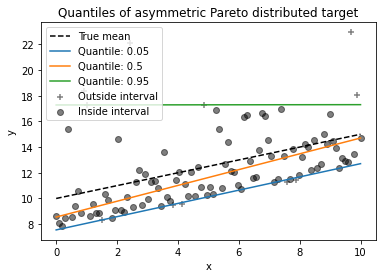

In [32]:
plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    x[out_bounds_predictions],
    y_pareto[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y_pareto[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of asymmetric Pareto distributed target")

Из-за асимметрии распределения шума мы наблюдаем, что истинное среднее значение и предполагаемая условная медиана различаются. Мы также наблюдаем, что каждая модель квантиля имеет разные параметры, чтобы лучше соответствовать желаемому квантилю. Обратите внимание, что в идеале в этом случае все квантили должны быть параллельными, что станет более заметным при увеличении количества точек данных или менее экстремальных квантилей, например, 10% и 90%.

В этом разделе мы остановимся на разнице в отношении ошибки, которую QuantileRegressorи LinearRegressionминимизируют.

Действительно, LinearRegressionэто метод наименьших квадратов, сводящий к минимуму среднеквадратичную ошибку (MSE) между тренировочными и прогнозируемыми целями. Напротив, QuantileRegressorwith quantile=0.5 минимизирует среднюю абсолютную ошибку (MAE).

Давайте сначала вычислим ошибки обучения таких моделей с точки зрения среднеквадратичной ошибки и средней абсолютной ошибки. Мы будем использовать асимметричную цель с распределением по Парето, чтобы сделать ее более интересной, поскольку среднее значение и медиана не равны.

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

linear_regression = LinearRegression()
quantile_regression = QuantileRegressor(quantile=0.5, alpha=0)

y_pred_lr = linear_regression.fit(X, y_pareto).predict(X)
y_pred_qr = quantile_regression.fit(X, y_pareto).predict(X)

print(
    f"""Training error (in-sample performance)
    {linear_regression.__class__.__name__}:
    MAE = {mean_absolute_error(y_pareto, y_pred_lr):.3f}
    MSE = {mean_squared_error(y_pareto, y_pred_lr):.3f}
    {quantile_regression.__class__.__name__}:
    MAE = {mean_absolute_error(y_pareto, y_pred_qr):.3f}
    MSE = {mean_squared_error(y_pareto, y_pred_qr):.3f}
    """
)

Training error (in-sample performance)
    LinearRegression:
    MAE = 1.805
    MSE = 6.486
    QuantileRegressor:
    MAE = 1.670
    MSE = 7.025
    


На обучающей выборке мы видим, что MAE ниже QuantileRegressorдля LinearRegression. В отличие от этого, MSE ниже LinearRegressionдля QuantileRegressor. Эти результаты подтверждают, что MAE — это потери, минимизированные , QuantileRegressor тогда как MSE — это минимизированные потери LinearRegression.

Мы можем сделать аналогичную оценку, но посмотрев на ошибку теста, полученную перекрестной проверкой.

In [24]:
from sklearn.model_selection import cross_validate

cv_results_lr = cross_validate(
    linear_regression,
    X,
    y_pareto,
    cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error"],
)
cv_results_qr = cross_validate(
    quantile_regression,
    X,
    y_pareto,
    cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error"],
)
print(
    f"""Test error (cross-validated performance)
    {linear_regression.__class__.__name__}:
    MAE = {-cv_results_lr["test_neg_mean_absolute_error"].mean():.3f}
    MSE = {-cv_results_lr["test_neg_mean_squared_error"].mean():.3f}
    {quantile_regression.__class__.__name__}:
    MAE = {-cv_results_qr["test_neg_mean_absolute_error"].mean():.3f}
    MSE = {-cv_results_qr["test_neg_mean_squared_error"].mean():.3f}
    """
)

Test error (cross-validated performance)
    LinearRegression:
    MAE = 1.732
    MSE = 6.690
    QuantileRegressor:
    MAE = 1.679
    MSE = 7.129
    
